In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

from datetime import datetime, timedelta
import time

from tqdm import tqdm_notebook

from haversine import haversine

import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error 

import gc
gc.collect()

0

# 1. 데이터 Load

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['pickup_datetime','dropoff_datetime'])
test = pd.read_csv('data/test.csv', parse_dates=['pickup_datetime'])
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
train.shape, test.shape, sample_submission.shape

((1458644, 11), (625134, 9), (625134, 2))

### df = train + test

In [4]:
df = pd.concat((train, test)) # (2083778, 11)
df.shape

(2083778, 11)

# 2.  EDA & 전처리 -> Feature Engineering

In [ ]:
train.info()

### 확인목록
#### object
id, store_and_fwd_flag  
#### int64         
vendor_id           

#### datetime64
pickup_datetime, dropoff_datetime         

In [ ]:
# object
## id 중복 확인
df[df.duplicated(['id'])]

In [ ]:
# datetime64
train.pickup_datetime.min(), train.pickup_datetime.max()
test.pickup_datetime.min(), test.pickup_datetime.max()

- 2016-01~2016-06 까지 동일한 기간의 다른 id 데이터 

In [ ]:
train.describe(include='all')

### Missing Value

In [ ]:
missingno.matrix(df, figsize = (15,8))

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

null value 없음

### Value Counts

In [5]:
def value_counts(df, cols):
    for col in cols:
        print(col)
        print(df[col].value_counts(),'\n')
        
value_counts(df, ['vendor_id', 'store_and_fwd_flag'])        

vendor_id
2    1114676
1     969102
Name: vendor_id, dtype: int64 

store_and_fwd_flag
N    2072303
Y      11475
Name: store_and_fwd_flag, dtype: int64 



In [6]:
# store_and_fwd_flag 값 변환
train['store_and_fwd_flag'] = np.where(train.store_and_fwd_flag == 'N', 0, 1)
test['store_and_fwd_flag'] = np.where(test.store_and_fwd_flag == 'N', 0, 1)
value_counts(train, ['store_and_fwd_flag'])        
value_counts(test, ['store_and_fwd_flag'])        

store_and_fwd_flag
0    1450599
1       8045
Name: store_and_fwd_flag, dtype: int64 

store_and_fwd_flag
0    621704
1      3430
Name: store_and_fwd_flag, dtype: int64 



## 시각화

In [ ]:
train.boxplot(figsize=(18, 8))

(1458640, 11)

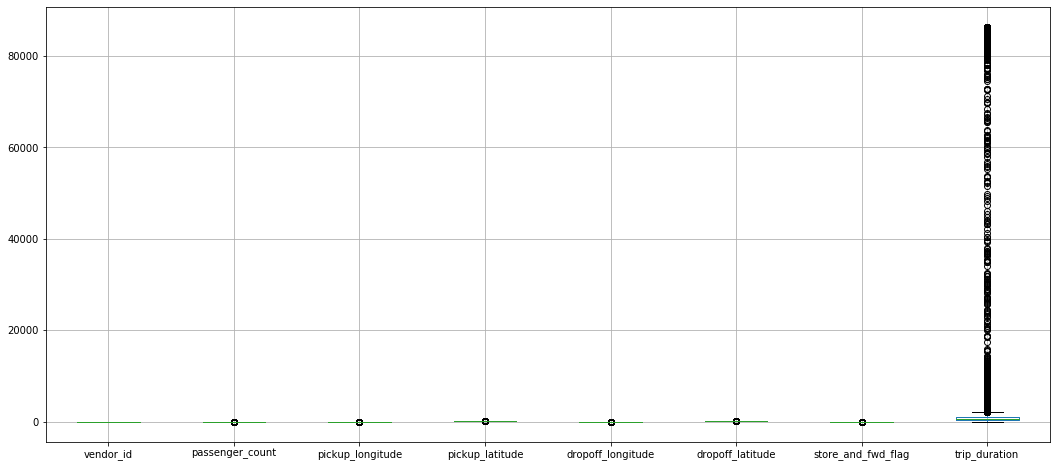

In [7]:
# trip_duration 비정상적으로 큰 4건 제외
train = train[(train.trip_duration < 90000)]
train.shape
train.boxplot(figsize=(18, 8))

In [ ]:
train.trip_duration.hist(bins=1000)

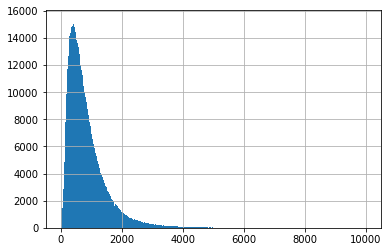

In [8]:
train[train.trip_duration < 10000]['trip_duration'].hist(bins=1000)

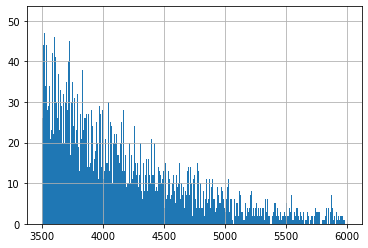

In [9]:
cond = (train.trip_duration > 3500) & (train.trip_duration < 6000)
train[cond]['trip_duration'].hist(bins=1000)

(1456077, 11)

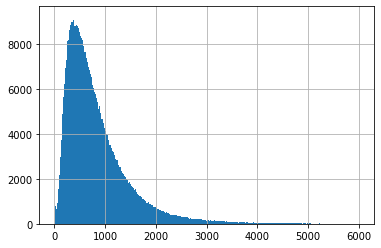

In [10]:
train = train[(train.trip_duration < 6000)]
train.shape
train.trip_duration.hist(bins=1000)

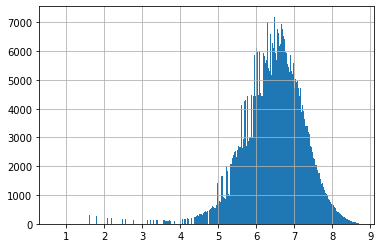

In [11]:
np.log1p(train.trip_duration).hist(bins=1000)
train['trip_duration'] = np.log1p(train.trip_duration)

### passenger_count outlier

In [12]:
cond = (train.passenger_count == 0)
train[cond].shape

idx = train[cond].index
idx

train = train.drop(idx)

(59, 11)

Int64Index([ 136519,  194288,  217765,  263809,  278290,  301600,  303133,
             337809,  375972,  383407,  412172,  415843,  437735,  447838,
             521316,  553862,  582469,  621221,  649337,  676906,  718163,
             722399,  727514,  776276,  777319,  796361,  827485,  875056,
             904688,  911071,  914211,  919750,  921640,  934078,  954696,
             986189, 1025067, 1032513, 1049209, 1092678, 1101359, 1122417,
            1131166, 1144278, 1211269, 1257574, 1262950, 1265736, 1276436,
            1280443, 1293792, 1296239, 1364548, 1368627, 1371117, 1414111,
            1433427, 1443353, 1444936],
           dtype='int64')

### 위도 경도
 - pickup_longitude, pickup_latitude -> dropoff_longitude dropoff_latitude

#### pickup

In [ ]:
plt.scatter(train.pickup_longitude, train.pickup_latitude)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')

In [13]:
train[train.pickup_longitude < -90]
train[train.pickup_latitude > 47]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1068810,id3777240,2,2016-01-27 18:26:40,2016-01-27 18:45:05,2,-121.933235,37.389297,-121.933205,37.389103,0,7.008505
1184454,id2854272,2,2016-02-26 13:50:19,2016-02-26 13:58:38,2,-121.933342,37.389381,-121.933304,37.389511,0,6.214608


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,0,6.675823


In [14]:
train = train[train.pickup_longitude > -90]
train = train[train.pickup_latitude < 47]

In [ ]:
plt.scatter(train.pickup_longitude, train.pickup_latitude)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')

#### dropoff

In [ ]:
plt.scatter(train.dropoff_longitude, train.dropoff_latitude)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')

#### 위도 경도 변화 
- 위도 경도 변화 없이 trip_duration 존재

In [ ]:
train[(train.pickup_longitude == train.dropoff_longitude) & (train.pickup_latitude == train.dropoff_latitude)]

In [15]:
idx = train[(train.pickup_longitude == train.dropoff_longitude) & (train.pickup_latitude == train.dropoff_latitude)].index
train = train.drop(idx)
train.shape

(1450129, 11)

### 거리 
 - haversine 함수로 구하면 시간 오래걸림

In [16]:
#Function aiming at calculating distances from coordinates
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

train['distance'] = ft_haversine_distance(train['pickup_latitude'].values,
                                                 train['pickup_longitude'].values, 
                                                 train['dropoff_latitude'].values,
                                                 train['dropoff_longitude'].values)
test['distance'] = ft_haversine_distance(test['pickup_latitude'].values, 
                                                test['pickup_longitude'].values, 
                                                test['dropoff_latitude'].values, 
                                                test['dropoff_longitude'].values)

In [ ]:
pd.concat((train['distance'],test['distance'])).to_frame().boxplot()

In [17]:
train[train['distance'] > 600]
train[train['distance'] > 400]

train = train[train['distance'] < 400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,0,6.416732,891.214103


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
397526,id0982904,1,2016-04-28 13:32:14,2016-04-28 14:14:09,2,-73.870682,40.773598,-79.817978,38.963852,0,7.830426,545.853499
910072,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,0,5.717028,578.842818
923793,id1001696,1,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-73.972366,40.758633,-79.553535,43.674000,0,7.248504,562.235188
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,0,6.416732,891.214103
1013474,id3626673,1,2016-05-05 18:02:50,2016-05-05 18:18:23,1,-73.978912,40.756763,-79.338699,41.427902,0,6.839476,455.241204
1100676,id2644780,1,2016-05-03 16:24:07,2016-05-03 17:18:34,2,-73.991325,40.750023,-79.518616,43.921028,0,8.091933,574.875442


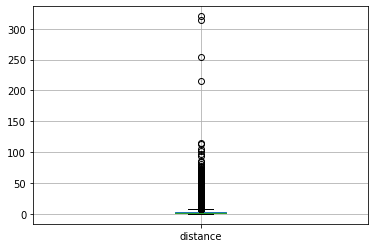

In [18]:
train.distance.to_frame().boxplot()

In [19]:
train[train['distance'] > 150]
train[train['distance'] < 150].sort_values(by='distance', ascending=False)

train = train[train['distance'] < 150]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354332,34.712234,-73.834923,32.181141,0,6.775366,314.764203
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,0,5.645447,320.125775
644165,id0401529,2,2016-06-02 15:19:35,2016-06-02 15:32:59,1,-73.980751,40.757111,-74.240051,38.478298,0,6.690842,254.363523
1060807,id0838705,1,2016-02-26 19:50:03,2016-02-26 20:08:54,1,-66.972160,44.371944,-69.048019,43.147583,0,7.031741,215.226573


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
978647,id0687776,2,2016-04-28 20:22:43,2016-04-28 22:01:25,1,-73.991928,40.751034,-72.912292,41.388992,0,8.686598,114.992275
283102,id2778014,2,2016-01-17 16:43:09,2016-01-17 16:50:16,1,-73.997086,40.728924,-72.671150,40.614220,0,6.059123,112.548872
595540,id1723416,1,2016-03-20 21:07:56,2016-03-20 21:12:35,1,-78.547401,40.817131,-79.786133,40.917637,0,5.634790,104.759971
512980,id2066082,1,2016-01-25 23:53:17,2016-01-26 01:25:46,1,-73.877716,40.772167,-72.905891,41.319832,0,8.621553,101.736296
823541,id1720250,2,2016-04-28 07:40:00,2016-04-28 08:54:28,1,-73.863960,40.769855,-72.720734,40.919106,0,8.404920,97.586212
...,...,...,...,...,...,...,...,...,...,...,...,...
1430706,id2556580,1,2016-05-10 17:13:32,2016-05-10 17:13:49,3,-73.995499,40.761387,-73.995499,40.761383,0,2.890372,0.000424
20077,id3733479,2,2016-05-22 03:58:40,2016-05-22 03:59:02,1,-74.347069,40.708519,-74.347069,40.708523,0,3.135494,0.000424
97396,id3748083,1,2016-01-28 22:39:27,2016-01-28 22:41:16,1,-73.986938,40.761074,-73.986938,40.761070,0,4.700480,0.000424
1060344,id0396704,1,2016-04-01 07:27:51,2016-04-01 07:28:33,3,-74.022278,40.759789,-74.022278,40.759792,0,3.761200,0.000424


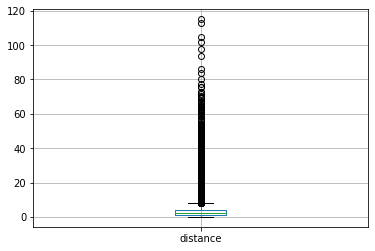

In [20]:
train.distance.to_frame().boxplot()

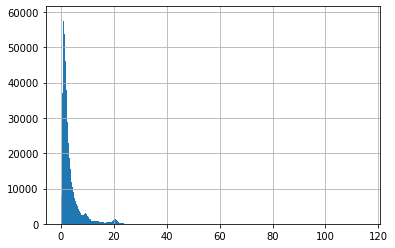

In [21]:
train['distance'].hist(bins=1000)

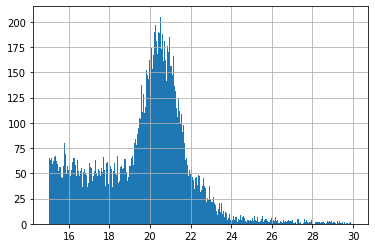

In [22]:
cond = (train.distance > 15) & (train.distance < 30)
train[cond]['distance'].hist(bins=1000)

In [23]:
train = train[train['distance'] < 30]

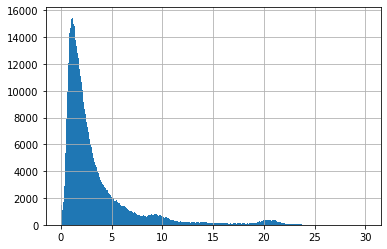

In [24]:
train['distance'].hist(bins=1000)

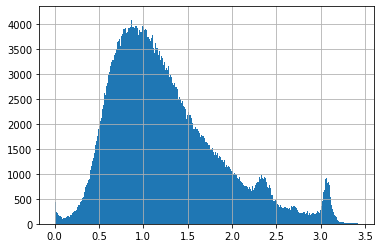

In [25]:
np.log1p(train['distance']).hist(bins=1000)
train['distance'] = np.log1p(train['distance'])
test['distance'] = np.log1p(test['distance'])

In [26]:
def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

#Add direction feature
train['direction'] = ft_degree(train['pickup_latitude'].values,
                                train['pickup_longitude'].values,
                                train['dropoff_latitude'].values,
                                train['dropoff_longitude'].values)
test['direction'] = ft_degree(test['pickup_latitude'].values,
                                  test['pickup_longitude'].values, 
                                  test['dropoff_latitude'].values,
                                  test['dropoff_longitude'].values)

### 속도

In [27]:
train['speed'] = train.distance / train.trip_duration
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,direction,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,6.122493,0.915699,99.970196,0.149563
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,6.498282,1.031584,-117.153768,0.158747
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661527,1.999464,-159.680165,0.260975
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,6.063785,0.910473,-172.737700,0.150149
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,6.077642,0.783257,179.473585,0.128875


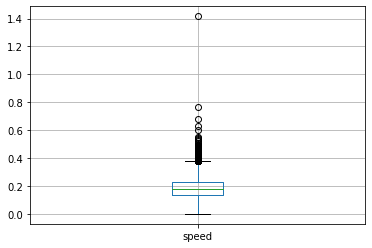

In [28]:
train['speed'].to_frame().boxplot()

In [29]:
train[train['speed'] > 1.4]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,direction,speed
1176337,id3619353,2,2016-02-13 20:28:30,2016-02-13 20:28:37,1,-73.936974,40.76461,-73.789848,40.646858,0,2.079442,2.946248,136.506188,1.416846


In [30]:
train = train[train['speed'] < 1.4]

In [31]:
train.drop(['speed'], axis=1, inplace=True)

### one-hot encoding

In [32]:
train = pd.concat([train, pd.get_dummies(train['store_and_fwd_flag'], prefix='store_and_fwd_flag')], axis=1)
test = pd.concat([test, pd.get_dummies(test['store_and_fwd_flag'], prefix='store_and_fwd_flag')], axis=1)

train = pd.concat([train, pd.get_dummies(train['vendor_id'], prefix='vendor_id')], axis=1)
test = pd.concat([test, pd.get_dummies(test['vendor_id'], prefix='vendor_id')], axis=1)

### 날짜 

In [33]:
train['month'] = train.pickup_datetime.dt.month
train['week'] = train.pickup_datetime.dt.week
train['weekday'] = train.pickup_datetime.dt.weekday
train['hour'] = train.pickup_datetime.dt.hour
train['minute'] = train.pickup_datetime.dt.minute
train['minute_oftheday'] = train['hour'] * 60 + train['minute']
train.drop(['minute'], axis=1, inplace=True)

test['month'] = test.pickup_datetime.dt.month
test['week'] = test.pickup_datetime.dt.week
test['weekday'] = test.pickup_datetime.dt.weekday
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test['minute_oftheday'] = test['hour'] * 60 + test['minute']
test.drop(['minute'], axis=1, inplace=True)

### 외부데이터 
 - https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm

In [34]:
fastest_routes_train_part_1 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fastest_routes_train_part_2 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
fastest_routes_train_part = pd.concat((fastest_routes_train_part_1, fastest_routes_train_part_2))

fastest_routes_test = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

In [35]:
train = train.merge(fastest_routes_train_part, how='left', on='id')
test = test.merge(fastest_routes_test, how='left', on='id')

In [ ]:
train.isna().sum().sum()
test.isna().sum().sum()

In [36]:
train.dropna(axis=0, inplace=True)

In [ ]:
train.isna().sum().sum()
test.isna().sum().sum()

### 클러스터링 

In [37]:
lat_long = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

kmeans = MiniBatchKMeans(n_clusters=3, init='k-means++').fit(lat_long)

train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [38]:
# Feature Extraction
time = np.vstack((train[['hour','weekday', 'distance']].values,
                    test[['hour','weekday', 'distance']].values
                   ))

kmeans = MiniBatchKMeans(n_clusters=2, init='k-means++').fit(time)

train.loc[:, 'time_cluster'] = kmeans.predict(train[['hour','weekday', 'distance']])
test.loc[:, 'time_cluster'] = kmeans.predict(test[['hour','weekday', 'distance']])

## 상관관계

- pickup_datetime 
- pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
- distance, total_distance
- store_and_fwd_flag_0, store_and_fwd_flag_1, vendor_id_1, vendor_id_2 
- month, week, weekday, hour, minute_oftheday
- number_of_steps 
- pickup_cluster, dropoff_cluster, time_cluster      
- dropoff_datetime, total_travel_time, trip_duration

In [ ]:
corr_cols = ['pickup_datetime'
, 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'
, 'distance', 'total_distance'
, 'store_and_fwd_flag_0', 'store_and_fwd_flag_1', 'vendor_id_1', 'vendor_id_2'
, 'month', 'week', 'weekday', 'hour', 'minute_oftheday'
, 'number_of_steps'
, 'pickup_cluster', 'dropoff_cluster', 'time_cluster'
, 'dropoff_datetime', 'total_travel_time', 'trip_duration']

In [ ]:
plt.figure(figsize=(30, 8))
sns.heatmap(train[corr_cols].corr(),annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

# 3. 모델 학습

In [39]:
from lightgbm import LGBMRegressor

## 데이터 준비

In [40]:
cols = [
'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'
, 'distance', 'total_distance'
, 'store_and_fwd_flag_0', 'store_and_fwd_flag_1', 'vendor_id_1', 'vendor_id_2'
, 'month', 'week', 'weekday', 'hour', 'minute_oftheday'
, 'number_of_steps'
, 'pickup_cluster', 'dropoff_cluster', 'time_cluster'
, 'total_travel_time']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(train[cols], train['trip_duration'], test_size=0.2, shuffle=True, random_state=42)

### Feature Extraction 

In [43]:
def importance_plotting(data, xlabel, ylabel, n=20):
    sns.set(style="whitegrid")
    ax = data.tail(n).plot(kind='barh')
    
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    plt.show()

In [44]:
lgb_reg.fit(train[cols], train['trip_duration'])

LGBMRegressor(bagging_fraction=0.5, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.1, max_bin=1000,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1,
              num_boost_round=1000, num_leaves=1000, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

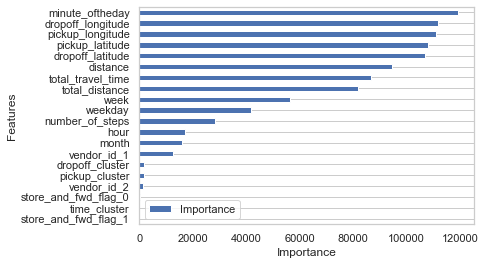

In [45]:
fi = {'Features':cols, 'Importance':lgb_reg.feature_importances_}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Importance', ascending=True)

importance_plotting(importance, 'Importance', 'Features', 20)

In [46]:
cols = [
'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'
, 'distance', 'total_distance'
#, 'store_and_fwd_flag_0', 'store_and_fwd_flag_1'
, 'vendor_id_1'#, 'vendor_id_2'
, 'month', 'week', 'weekday', 'hour', 'minute_oftheday'
, 'number_of_steps'
#, 'pickup_cluster', 'dropoff_cluster', 'time_cluster'
, 'total_travel_time']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train[cols], train['trip_duration'], test_size=0.2, shuffle=True, random_state=42)

In [93]:
gc.collect()

196

## 하이퍼파라미터 튜닝

In [94]:
%%time
lgb_reg = LGBMRegressor(n_jobs=-1, random_state=42, learning_rate=0.1
                        , n_estimators=400, max_depth=15
                        , num_leaves=1400
                        , bagging_fraction=0.4, feature_fraction=0.9
                        , max_bin=1200
                        #, num_boost_round=1000
                       )

max_features = [400, 500]

params = {'max_features': max_features
         }

gscv = GridSearchCV(lgb_reg, param_grid=params, scoring='neg_mean_squared_error', cv=3)
gscv.fit(X_train, y_train)

rmse = np.sqrt(-1* gscv.best_score_)

print(rmse, gscv.best_params_)

0.3130402736927324 {'reg_lambda': 20}
Wall time: 7min 52s


## 모델 훈련

In [219]:
gc.collect()

20

In [227]:
gc.collect()

lgb_reg = LGBMRegressor(n_jobs=-1, random_state=42
                        , max_depth=30
                        , num_leaves=800
                        , feature_fraction=0.9
                        , learning_rate=0.01, num_iterations=1000
                        
                        
                        #, max_features=0.2
                        , num_boost_round=1000
                       )

lgb_reg.fit(train[cols], train['trip_duration'])
predictions = lgb_reg.predict(test[cols])
submission = pd.DataFrame({'id': test.id, 'trip_duration': np.expm1(predictions)})
submission.to_csv("./output/bagging_fraction-1.csv", index=False)

71

LGBMRegressor(bagging_fraction=0.1, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.01, max_depth=30,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_boost_round=1000,
              num_iterations=1000, num_leaves=800, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
0.40464 -
0.40464 5


In [ ]:
importance

# 4. 예측

In [104]:
predictions = lgb_reg.predict(test[cols])

# 5. 제출

In [105]:
submission = pd.DataFrame({'id': test.id, 'trip_duration': np.expm1(predictions)})
submission.to_csv("./output/20200905-10.csv", index=False)

In [106]:
gc.collect()

151